# Actor-critic
行動を決定する（方策，政策）actorと，その行動を評価するcriticから成る．
$\varepsilon$-グリーディ法などを用いて確率的方策を実現するQ学習とは異なり，actorが直接的に方策を学習する．
CriticはTD誤差に基づいて，actorの方策をどのように更新すれば良いかという情報（方策勾配）を提供する．Critic自体はTD学習によって状態価値関数を学習する．

In [21]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

import tensorflow as tf
import gym

def run_simulation(env, step_fn):
    fig = plt.figure()
    array = env.render(mode='rgb_array')
    im = plt.imshow(array, animated=True)
    plt.xticks([])
    plt.yticks([])
    text = plt.text(10,array.shape[0]-10,'')

    def update(*args):
        info = step_fn()
        im.set_array(env.render(mode='rgb_array'))
        text.set_text(info)
        return im, text
    
    global _ani
    _ani = animation.FuncAnimation(fig, update, interval=50, blit=True)
    plt.show()

## 行動選択
特定の確率分布のパラメータを状態の関数として計算し，その確率分布から乱数を生成する．
確率分布として以下の正規分布が使われることが非常に多い．
$$
\pi(s,a)=\frac{1}{\sqrt{2\pi\sigma^2(s)}}\exp\left(-\frac{1}{2\sigma^2(s)}(a-\mu(s))^2\right)
$$
この場合，平均$\mu(s)$，分散$\sigma^2(s)$を状態$s$の関数として定義し，それらを学習することになる．

<IPython.core.display.Javascript object>


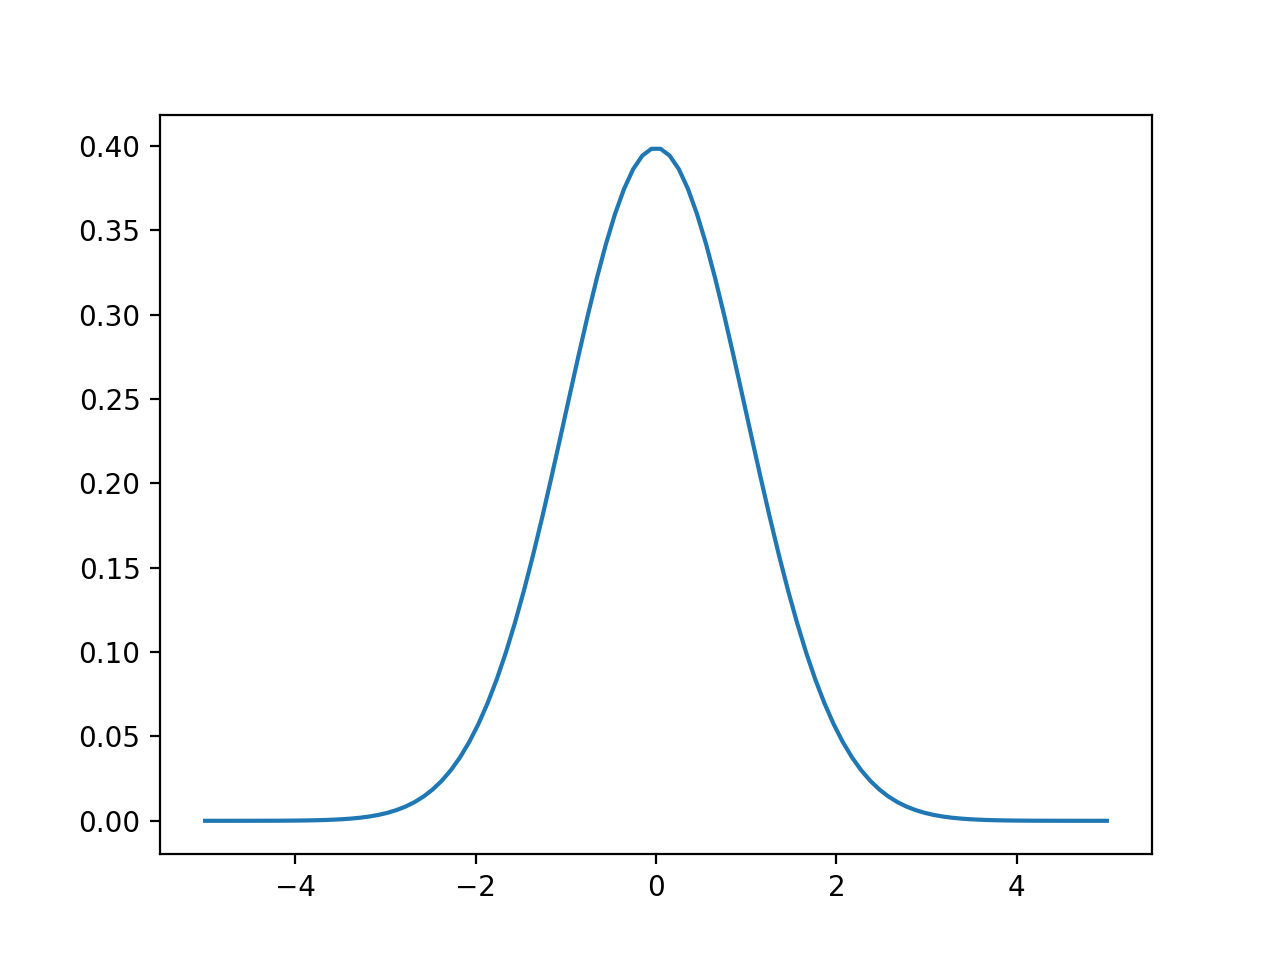

[ 0.5911977  -0.84200585  1.0635223  -0.2184073   0.47981933 -0.6591812
  0.304323    1.1081047   0.7240305  -1.2762021 ]
[-0.92712694 -0.27335775  0.23938572 -2.3009458  -0.40757105  0.23876143
  0.04576457  0.20665339  0.30250216  1.9246172 ]


In [22]:
def normal_distribution_pdf(x, mu, sigma):
    return tf.exp(-((x-mu)/sigma)**2/2.)/(tf.sqrt(2*np.pi)*sigma)

plt.figure(u'正規分布の確率密度関数')
with tf.Session():
    x = tf.linspace(-5.,5.,100)
    p = normal_distribution_pdf(x, 0., 1.)
    plt.plot(x.eval(), p.eval())
    plt.show()

    # 正規乱数の生成（引数は配列のshape，平均，標準偏差）
    rand = tf.random.normal([10], 0., 1.)
    print(rand.eval())
    # このテンソルは評価される毎に値が異なる
    print(rand.eval())

## 状態価値関数の更新
TD誤差の二乗
$$
\frac{1}{2}\left(r_{t+1}+\gamma\hat{V}(s_{t+1}) - \hat{V}(s_t)\right)^2
$$
を$\hat{V}$について，またはそのパラメータについて最小化する．この式を微分すると以下の更新則が得られる．

### 状態が有限個の場合
$$
\hat{V}(s_t)\leftarrow \hat{V}(s_t) + \alpha\left(r_{t+1}+\gamma\hat{V}(s_{t+1}) - \hat{V}(s_t)\right)
$$
### 状態が連続値の場合
状態価値関数のパラメータを$w$とすると
$$
w\leftarrow w+\alpha\left(r_{t+1}+\gamma\hat{V}(s_{t+1};w) - \hat{V}(s_t;w)\right)\frac{\partial}{\partial w}V(s_t;w).
$$

## 方策の更新
Actorの学習は，TD誤差が正の（行動後の収益見込みが行動前の予測より高かった）場合にその行動を強化（より高い確率に）するように学習する．方策のパラメータを$w$とすると
$$
w\leftarrow w+\alpha\left(r_{t+1}+\gamma\hat{V}(s_{t+1};w) - \hat{V}(s_t;w)\right)\frac{\partial}{\partial w}\log\pi(s_t,a_t;w).
$$

In [23]:
# 割引率
gamma = 0.98
# 学習率
critic_learning_rate = 0.001
actor_learning_rate = 0.001

# ニューラルネットワークの活性化関数
def activation(x):
    # x < 0 のとき傾き0.1， x > 0 のとき傾き1となる
    return 0.1 * x + 0.9 * tf.nn.relu(x)

# ３層ニューラルネットワークのパラメータを用意する
def neural_network_vars(num_input, num_hidden, num_output):
    initializer = tf.contrib.layers.xavier_initializer()
    w1 = tf.Variable(initializer([num_input, num_hidden]))
    b1 = tf.Variable(tf.zeros([num_hidden]))
    w2 = tf.Variable(initializer([num_hidden, num_output]))
    b2 = tf.Variable(tf.zeros([num_output]))
    return [w1, b1, w2, b2]
    
# 3層ニューラルネットワーク
def neural_network(x, params):
    w1, b1, w2, b2 = params
    # hidden layer
    h = tf.matmul(x, w1) + b1
    h = tf.tanh(h)
    # output layer
    y = tf.matmul(h, w2) + b2
    return y

# 3変数2次式のパラメータを用意する
def quadratic_vars(num_input, num_output):
    initializer = tf.contrib.layers.xavier_initializer()
    b = tf.Variable(tf.zeros([num_output]))
    v = tf.Variable(initializer([3, num_output]))
    w11 = tf.Variable(tf.zeros([num_output]))
    w12 = tf.Variable(tf.zeros([num_output]))
    w13 = tf.Variable(tf.zeros([num_output]))
    w22 = tf.Variable(tf.zeros([num_output]))
    w23 = tf.Variable(tf.zeros([num_output]))
    w33 = tf.Variable(tf.zeros([num_output]))
    return b, v, w11, w12, w13, w22, w23, w33

# 3変数2次式
def quadratic(x, params):
    b, v, w11, w12, w13, w22, w23, w33 = params
    y = tf.expand_dims(b, 0)
    y += tf.matmul(x, v)
    y += x[:,0:1]*x[:,0:1] * tf.expand_dims(w11, 0)
    y += x[:,0:1]*x[:,1:2] * tf.expand_dims(w12, 0)
    y += x[:,0:1]*x[:,2:3] * tf.expand_dims(w13, 0)
    y += x[:,1:2]*x[:,1:2] * tf.expand_dims(w22, 0)
    y += x[:,1:2]*x[:,2:3] * tf.expand_dims(w23, 0)
    y += x[:,2:3]*x[:,2:3] * tf.expand_dims(w33, 0)
    return y

# RBFネットワークのパラメータを用意する
def rbf_network_vars(num_theta, num_omega, num_output):
    return [tf.Variable(tf.truncated_normal([num_theta, num_omega, num_output],
                                            stddev=.3))]
    
# RBFネットワーク
def rbf_network(x, params):
    w, = params
    num_theta = w.get_shape()[0].value
    num_omega = w.get_shape()[1].value
    theta_list = tf.linspace(0., 2*np.pi, num_theta)
    omega_list = tf.linspace(-8., 8., num_omega)
    theta, omega = tf.meshgrid(theta_list, omega_list)
    mu = tf.stack([tf.cos(theta), tf.sin(theta), omega], 0)
    sigma = tf.constant([2*np.pi/num_theta, 2*np.pi/num_theta, 16./num_omega]) * 2.
    
    d = tf.expand_dims(tf.expand_dims(x,2),3)-tf.expand_dims(mu,0)
    g = tf.exp(-tf.reduce_sum((d / tf.reshape(sigma, [1,3,1,1]))**2/2., 1))
    return tf.reduce_sum(tf.reduce_sum(tf.expand_dims(g,3) * tf.expand_dims(w,0), 2), 1)

env = gym.make('Pendulum-v0')

# グラフの生成
graph = tf.Graph()
with graph.as_default():
    # 状態
    state = tf.placeholder(tf.float32, shape=[3])
    next_state = tf.placeholder(tf.float32, shape=[3])

    # 報酬
    reward = tf.placeholder(tf.float32, shape=[])

    # 方策
    #actor_vars = neural_network_vars(3, 10, 2)
    #actor_vars = quadratic_vars(3, 2)
    actor_vars = rbf_network_vars(20, 20, 2)
    #out = neural_network(tf.expand_dims(state,0), actor_vars)[0]
    #out = quadratic(tf.expand_dims(state,0), actor_vars)[0]
    out = rbf_network(tf.expand_dims(state,0), actor_vars)[0]
    mu = tf.nn.sigmoid(out[0])
    mu = mu * (env.action_space.high[0] - env.action_space.low[0]) + env.action_space.low[0]
    sigma = tf.nn.sigmoid(out[1])
    sigma = sigma * (1.0 - 0.1) + 0.1
    action = tf.random.normal([1], mu, sigma)[0]
    policy = normal_distribution_pdf(tf.stop_gradient(action), mu, sigma)

    # 状態価値関数V(s)
    #critic_vars = neural_network_vars(3, 10, 1)
    #critic_vars = quadratic_vars(3, 1)
    critic_vars = rbf_network_vars(20, 20, 1)
    #V = neural_network(tf.expand_dims(state,0), critic_vars)[0,0]
    #V = quadratic(tf.expand_dims(state,0), critic_vars)[0,0]
    V = rbf_network(tf.expand_dims(state,0), critic_vars)[0,0]
    # stop_gradientに渡すことで，この項は微分されないようにする
    #next_V = tf.stop_gradient(neural_network(tf.expand_dims(next_state,0), critic_vars)[0,0])
    #next_V = tf.stop_gradient(quadratic(tf.expand_dims(next_state,0), critic_vars)[0,0])
    next_V = tf.stop_gradient(rbf_network(tf.expand_dims(next_state,0), critic_vars)[0,0])

    # TD誤差
    td_error = reward + gamma*next_V - V

    # 方策のパラメータで微分すると上記の方策の更新則が得られる
    policy_loss = -td_error*tf.log(policy)
    # Vのパラメータで微分すると上記のVの更新則が得られる
    value_loss = td_error**2/2

    actor_opt = tf.train.GradientDescentOptimizer(learning_rate=actor_learning_rate)
    critic_opt = tf.train.GradientDescentOptimizer(learning_rate=critic_learning_rate)
    # 評価すると方策の更新則が実行される
    update_actor = actor_opt.minimize(policy_loss, var_list=actor_vars)
    # 評価するとVの更新則が実行される
    update_critic = critic_opt.minimize(value_loss, var_list=critic_vars)

    # 方策とVの可視化のための計算
    vis_theta_list = tf.linspace(0., 2*np.pi, 100)
    vis_omega_list = tf.linspace(-8., 8., 100)
    vis_theta, vis_omega = tf.meshgrid(vis_theta_list, vis_omega_list)
    vis_x = tf.reshape(tf.cos(vis_theta), [-1])
    vis_y = tf.reshape(tf.sin(vis_theta), [-1])
    vis_omega = tf.reshape(vis_omega, [-1])
    vis_state = tf.stack([vis_x, vis_y, vis_omega], 1)
    #vis_out = neural_network(vis_state, actor_vars)
    #vis_out = quadratic(vis_state, actor_vars)
    vis_out = rbf_network(vis_state, actor_vars)
    vis_mu = tf.nn.sigmoid(vis_out[:,0]) * (env.action_space.high[0] - env.action_space.low[0]) + env.action_space.low[0]
    vis_mu = tf.reshape(vis_mu, tf.shape(vis_theta))
    vis_sigma = tf.nn.sigmoid(vis_out[:,1]) * (1.0 - 0.1) + 0.1
    vis_sigma = tf.reshape(vis_sigma, tf.shape(vis_theta))
    #vis_V = neural_network(vis_state, critic_vars)[:,0]
    #vis_V = quadratic(vis_state, critic_vars)[:,0]
    vis_V = rbf_network(vis_state, critic_vars)[:,0]
    vis_V = tf.reshape(vis_V, tf.shape(vis_theta))

    # 評価すると全ての変数を初期化する
    init_op = tf.global_variables_initializer()
    
    # 変数を保存するためのオブジェクト
    saver = tf.train.Saver()                             #全ての変数
    actor_saver = tf.train.Saver(var_list=actor_vars)    #actorの変数だけ
    critic_saver = tf.train.Saver(var_list=critic_vars)  #criticの変数だけ
    
# セッションの生成
sess = tf.Session(graph=graph)

# 変数の初期化
sess.run(init_op)

# 環境の初期化（注：_stateはテンソルではなく，実際の値）
_state = env.reset()

<IPython.core.display.Javascript object>


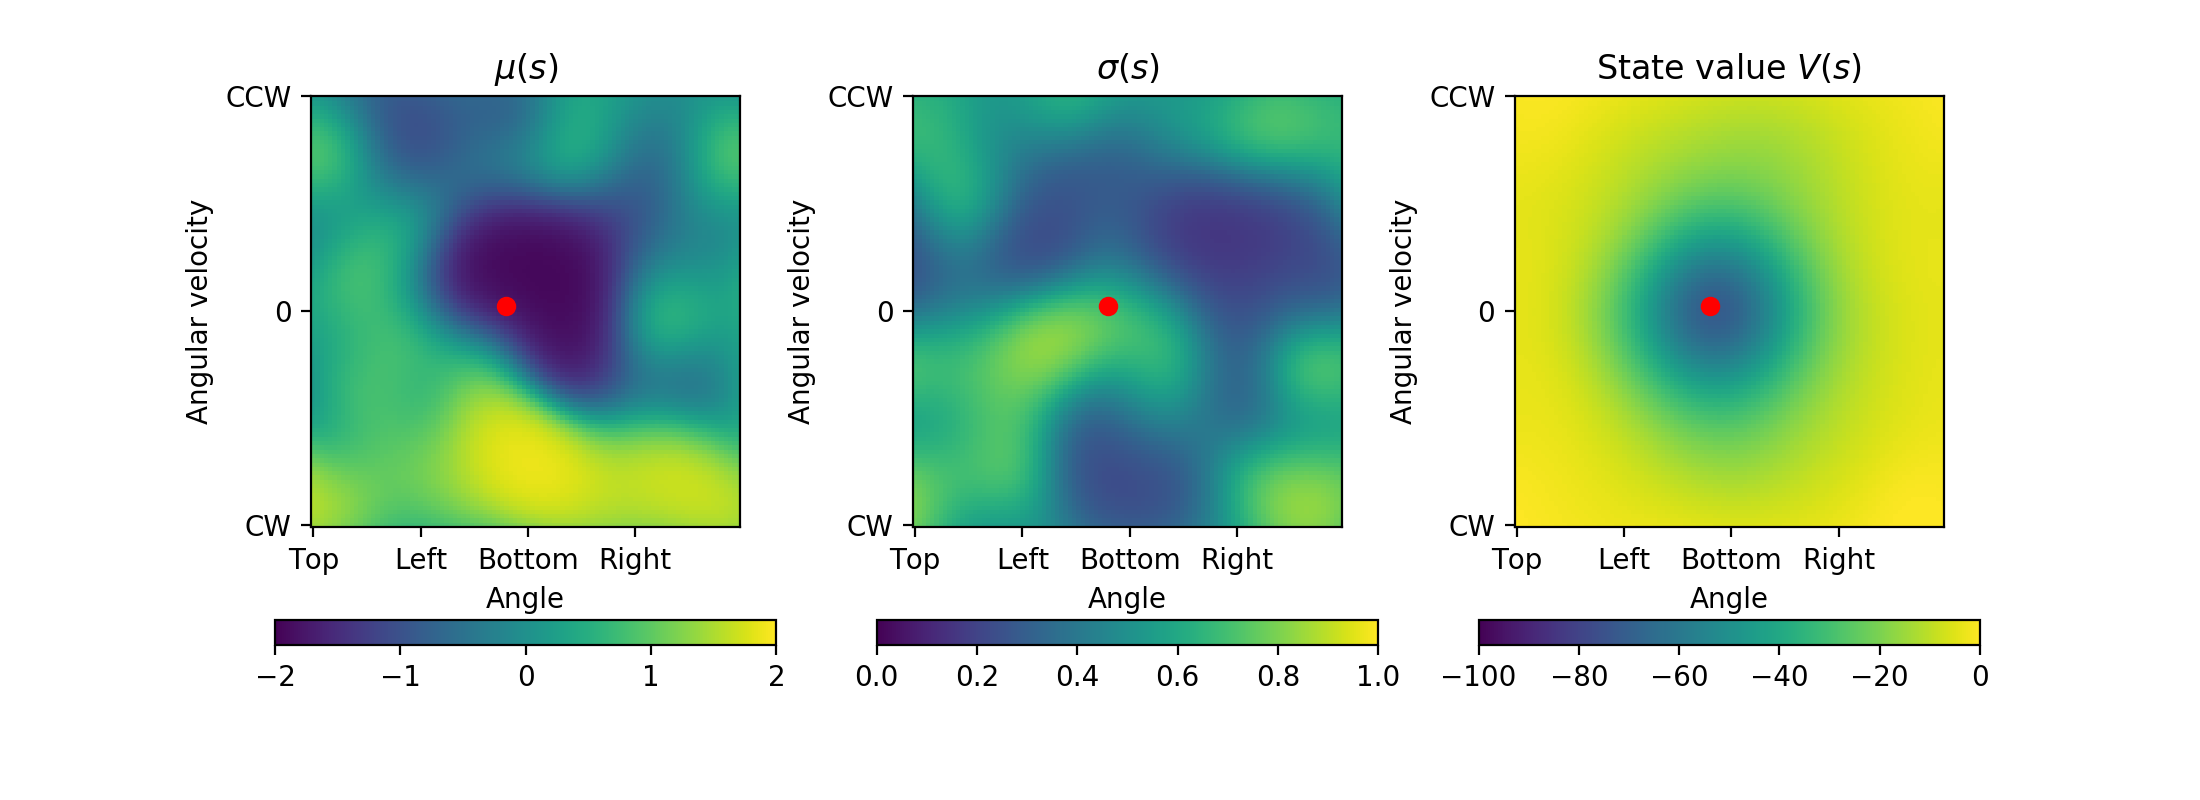

<IPython.core.display.Javascript object>


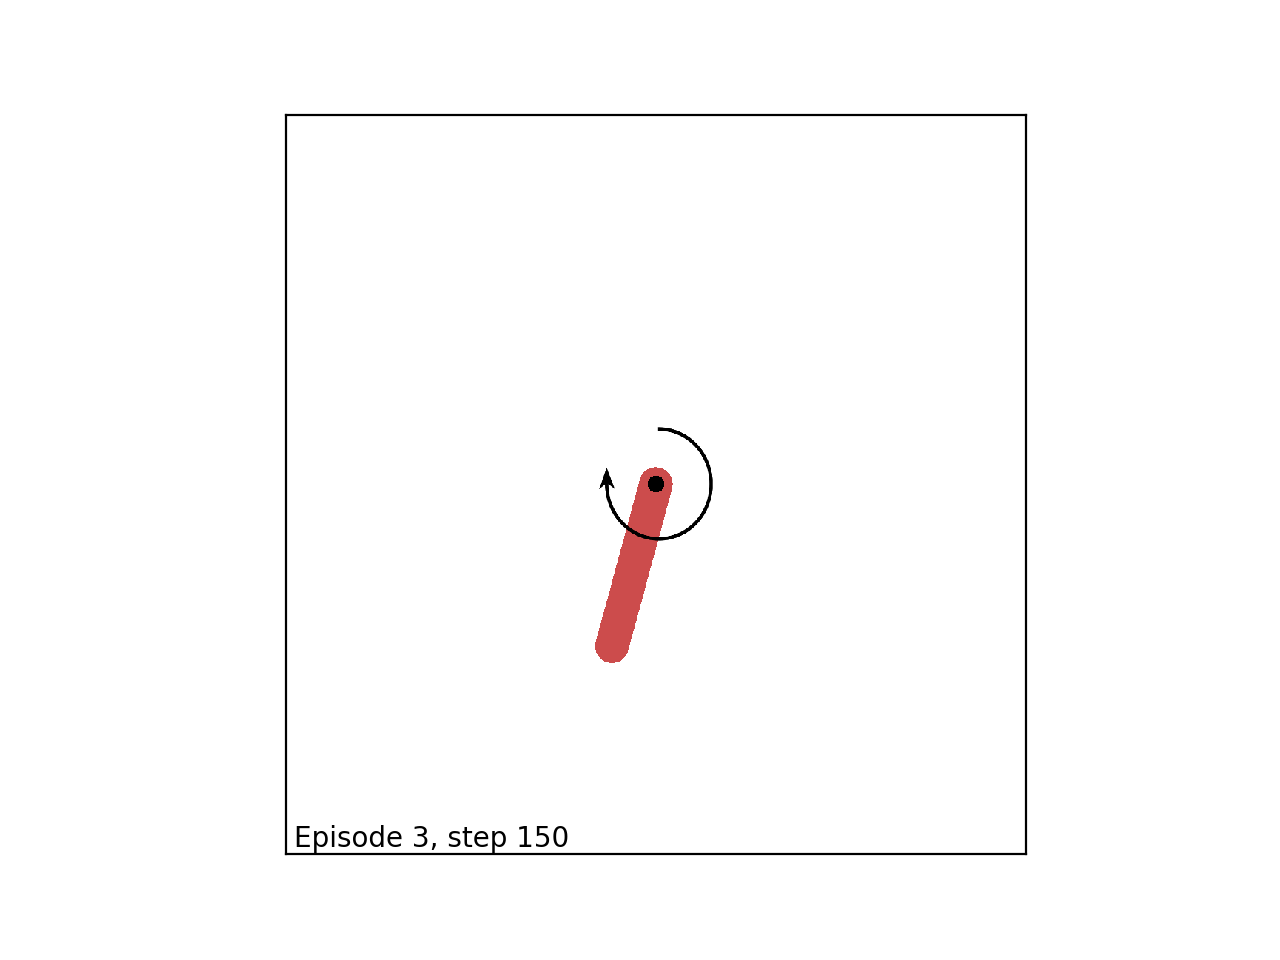

In [36]:
def plot_func(values, point):
    plt.imshow(values, origin='lower')
    plt.plot(point[0], point[1], 'ro')
    height, width = values.shape
    plt.xticks([0,width*1./4,width*2./4,width*3./4], ['Top','Left','Bottom','Right'])
    plt.xlabel('Angle')
    plt.yticks([0,height/2,height], ['CW',0,'CCW'])
    plt.ylabel('Angular velocity')
    plt.colorbar(orientation='horizontal')

plt.figure('Info', figsize=[11,4])
_vis_theta_list, _vis_omega_list = sess.run([vis_theta_list, vis_omega_list])
t = 0
episode = 1

def step():
    global _state, t, episode
    # 行動値の生成
    _action = sess.run(action, {state: _state})
    # 行動の実行
    _next_state, _reward, done, _ = env.step([_action])
    # パラメータの更新
    sess.run([update_actor, update_critic], {state: _state,
                                             action: _action, # 上のrunで生成されたactionを渡す
                                             next_state: _next_state,
                                             reward: _reward})
    
    # 方策と状態価値関数の可視化
    _vis_mu, _vis_sigma, _vis_V = sess.run([vis_mu, vis_sigma, vis_V])
    _theta = np.arctan2(_next_state[1], _next_state[0]) % (2*np.pi)
    theta_ind = np.abs(_vis_theta_list-_theta).argmin()
    omega_ind = np.abs(_vis_omega_list-_next_state[2]).argmin()
    
    plt.figure('Info')
    plt.clf()
    plt.subplot(1,3,1)
    plot_func(_vis_mu, [theta_ind, omega_ind])
    plt.clim([-2.,2.])
    plt.title('$\mu(s)$')
    plt.subplot(1,3,2)
    plot_func(_vis_sigma, [theta_ind, omega_ind])
    plt.clim([0.,1.])
    plt.title('$\sigma(s)$')
    plt.subplot(1,3,3)
    plot_func(_vis_V, [theta_ind, omega_ind])
    plt.clim([-100.,0.])
    plt.title('State value $V(s)$')
    
    # 次ステップへ移行
    t += 1
    _state = _next_state
    if done:
        _state = env.reset()
        episode += 1
        t = 0
    return 'Episode {}, step {}'.format(episode, t)

run_simulation(env, step)

## 変数の保存
以下のセルを実行すると全てのパラメータを保存／復元できる．

In [37]:
saver.save(sess, './actor_critic_vars')
#actor_saver.save(sess, './actor_vars')
#critic_saver.save(sess, './critic_vars')

'./critic_vars'

In [20]:
saver.restore(sess, './actor_critic_vars')
#actor_saver.restore(sess, './actor_vars')
#critic_saver.restore(sess, './critic_vars')

INFO:tensorflow:Restoring parameters from ./actor_critic_vars
